In [ ]:
!pip install matplotlib
!pip install sklearn
!pip install pandas
!pip install gensim
!pip install nltk
%matplotlib inline

In [10]:
# Importing modules
import pandas as pd
import os
import glob
import csv

# path for original transript csv files
# path = '/home/jovyan/Transcripts/'
# path for speaker grouped transript csv files
path = '/home/jovyan/GroupedTranscripts/'

allfiles = glob.glob(path + "*.csv")
fileList = []
for file in allfiles:
    df = pd.read_csv(file, header=None, sep='\n', quoting=csv.QUOTE_NONE, encoding='utf-8')
    fileList.append(df)

papers = pd.concat(fileList, axis=0, ignore_index=True)

# Print head
papers.head()
# papers.tail(20)


,0
0,CHAIRPERSON: Good morning Mr Pretorius. Goo...
1,ADV PRETORIUS SC: Good morning Chair. [m...
2,"MS K: Good morning. Yes, Chair I underst..."
3,INQUIRY RESUMES:
4,"COUNSEL: Thanks, Chair. Can we comfortably sit..."


In [11]:
# Load the regular expression library
import re
# Remove punctuation
papers['speech_processed'] = \
papers[0].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers['speech_processed'] = \
papers['speech_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers['speech_processed'].head()
# print(papers.shape)

0    chairperson:   good morning mr pretorius  good...
1    adv pretorius sc:   good morning chair     [mi...
2    ms k:   good morning     yes chair i understan...
3                               inquiry resumes:      
4    counsel: thanks chair can we comfortably sit d...
Name: speech_processed, dtype: object

In [12]:
# remove emojis
import re
papers = papers.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
papers.head()

,0,speech_processed
0,CHAIRPERSON: Good morning Mr Pretorius. Goo...,chairperson: good morning mr pretorius good...
1,ADV PRETORIUS SC: Good morning Chair. [m...,adv pretorius sc: good morning chair [mi...
2,"MS K: Good morning. Yes, Chair I underst...",ms k: good morning yes chair i understan...
3,INQUIRY RESUMES:,inquiry resumes:
4,"COUNSEL: Thanks, Chair. Can we comfortably sit...",counsel: thanks chair can we comfortably sit d...


In [13]:
# remove stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['ja', 'oh', 'chairperson', 'chair', 'mr', 'ms', 'go', 'yes', 'no', 'say', 'know', 'see', 'one', 'neh','adv', 'intervenes', 'okay'])
papers['speech_processed1'] = papers['speech_processed'].apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop_words))
papers['speech_processed1'].head()

0    chairperson: good morning pretorius good morni...
1    pretorius sc: good morning [microphone muted] ...
2    k: good morning understand (suo) able confirm ...
3                                     inquiry resumes:
4    counsel: thanks comfortably sit avoided interr...
Name: speech_processed1, dtype: object

Loading dataset...
done in 0.000s.
Extracting tf-idf features for NMF...
done in 0.039s.
Extracting tf features for LDA...
done in 0.027s.

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


done in 0.916s.


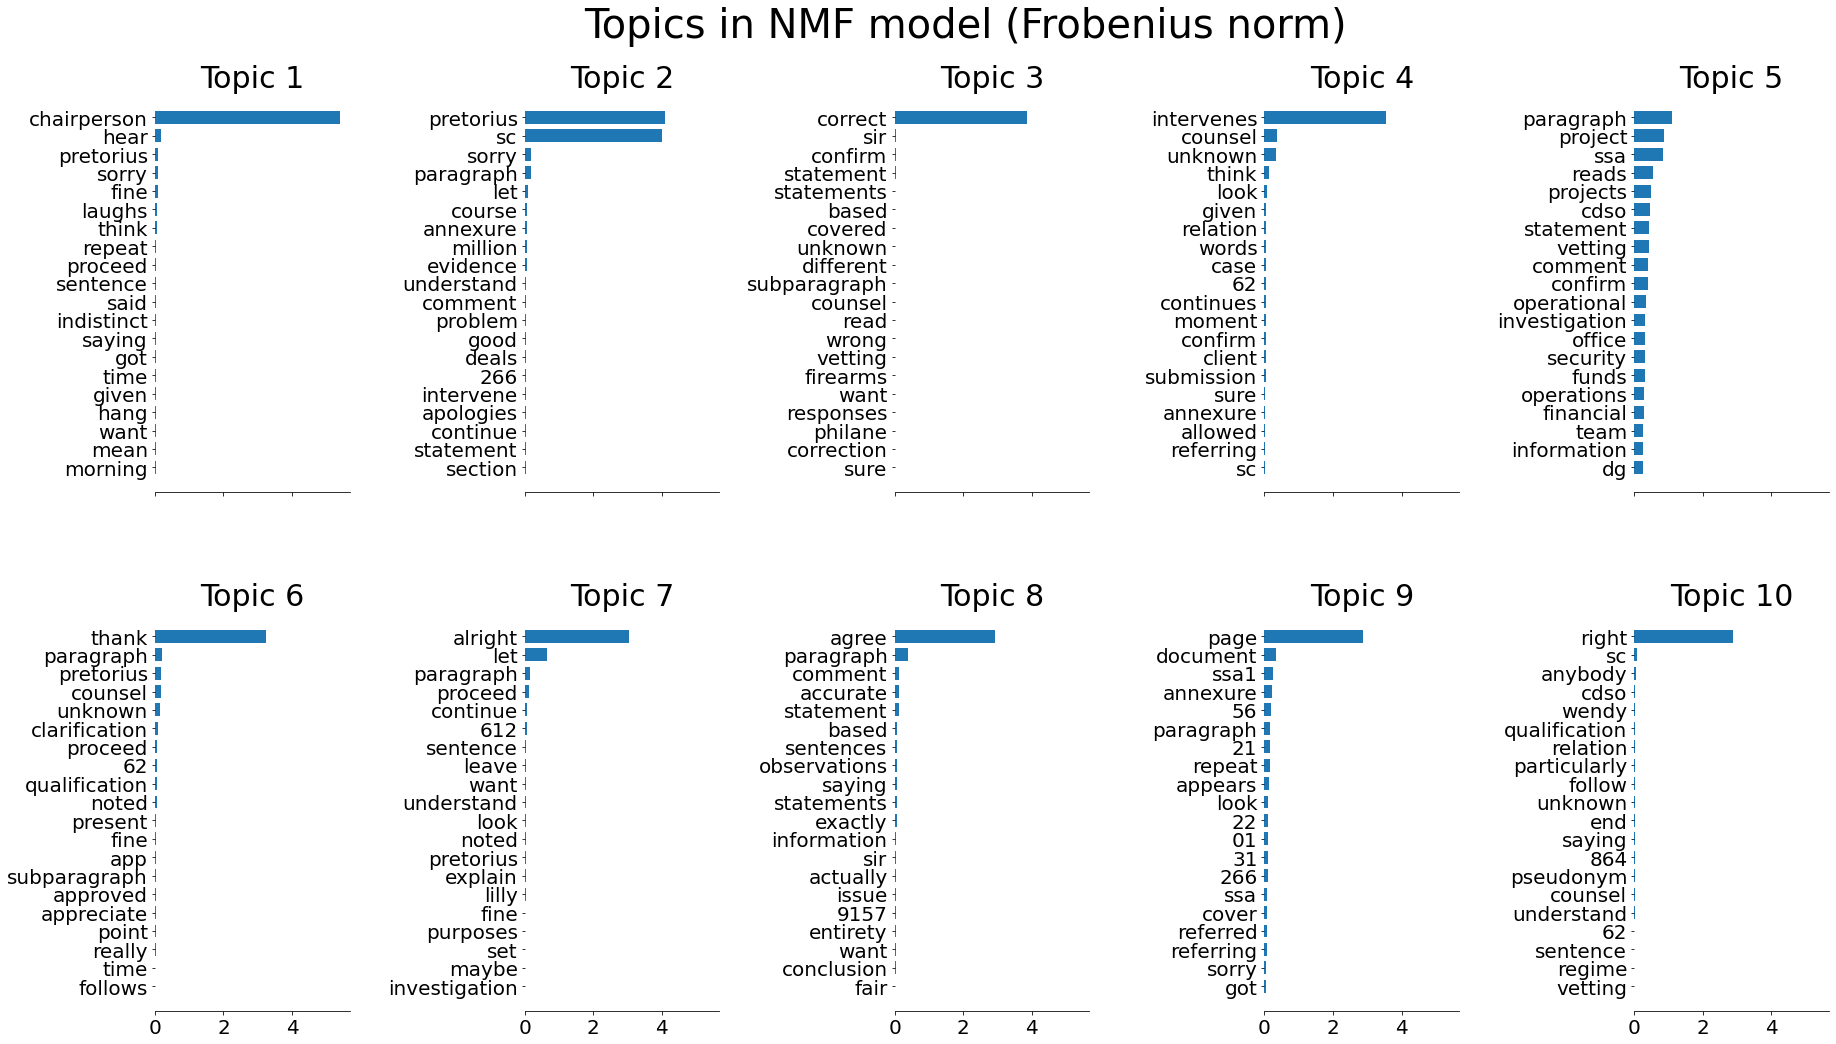



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


done in 2.113s.


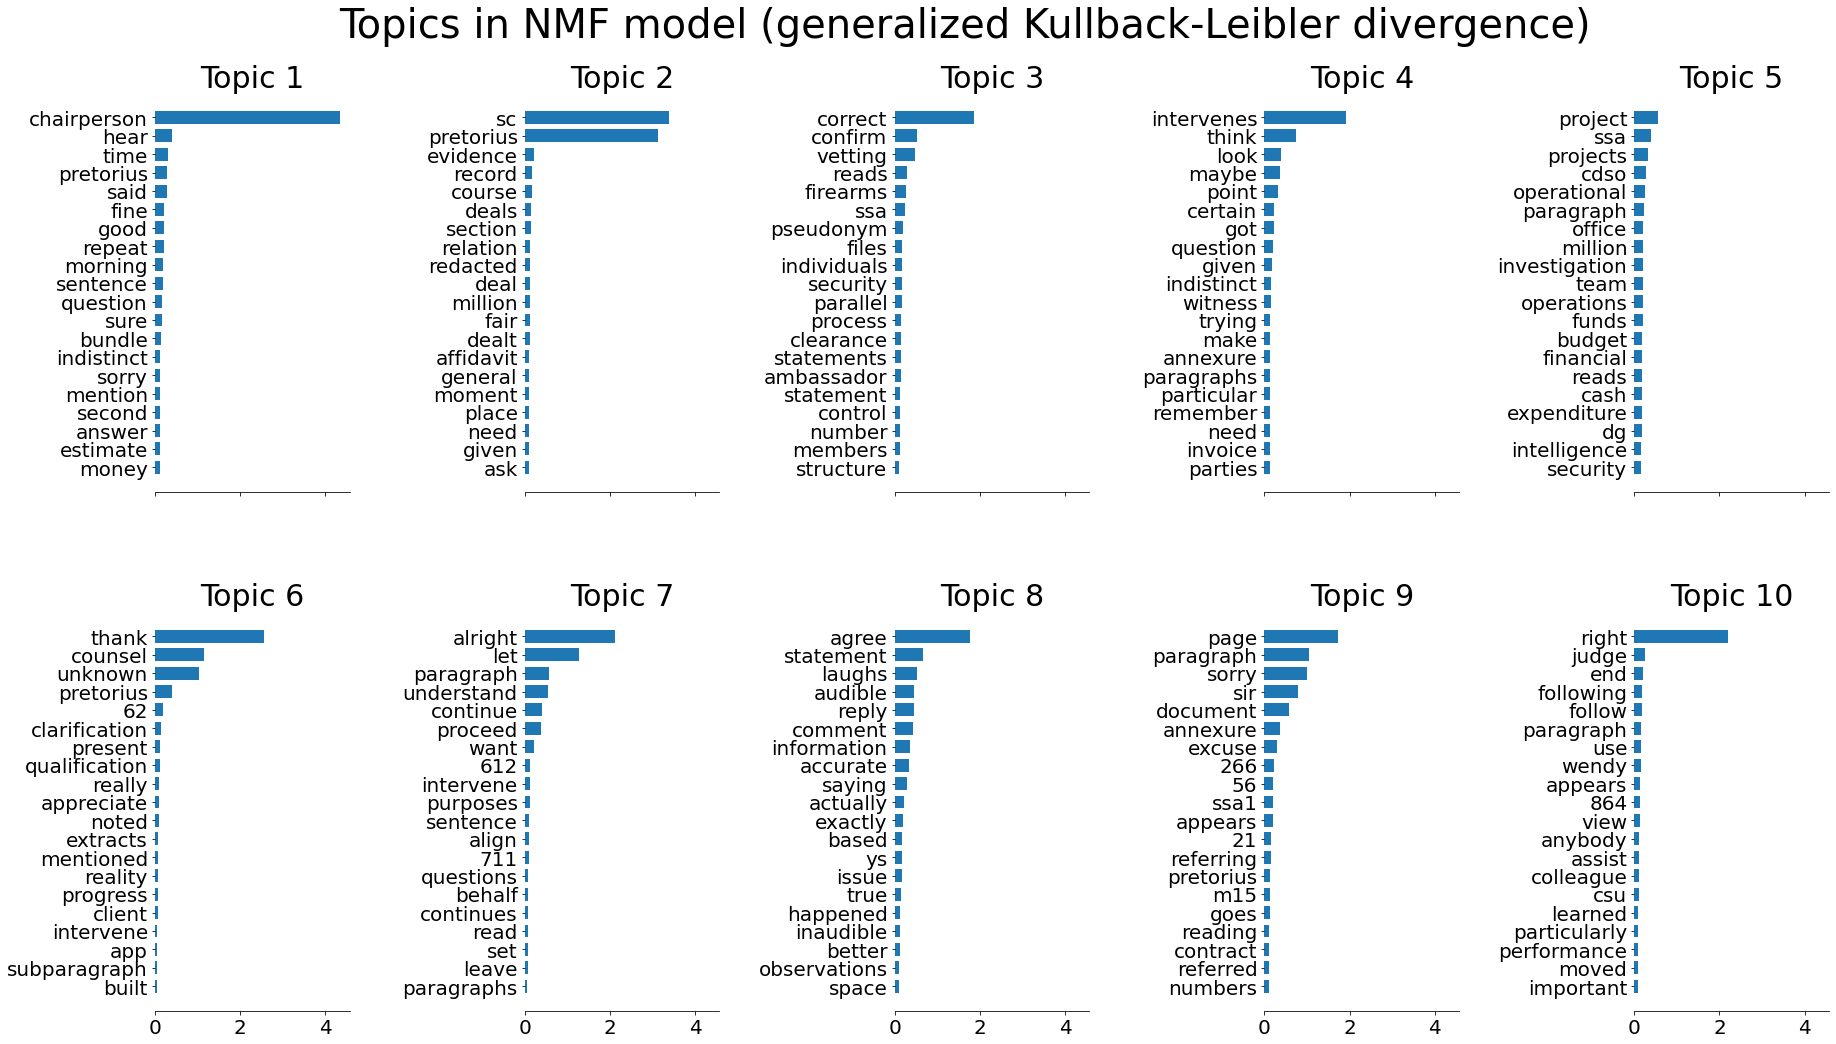



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 1.636s.


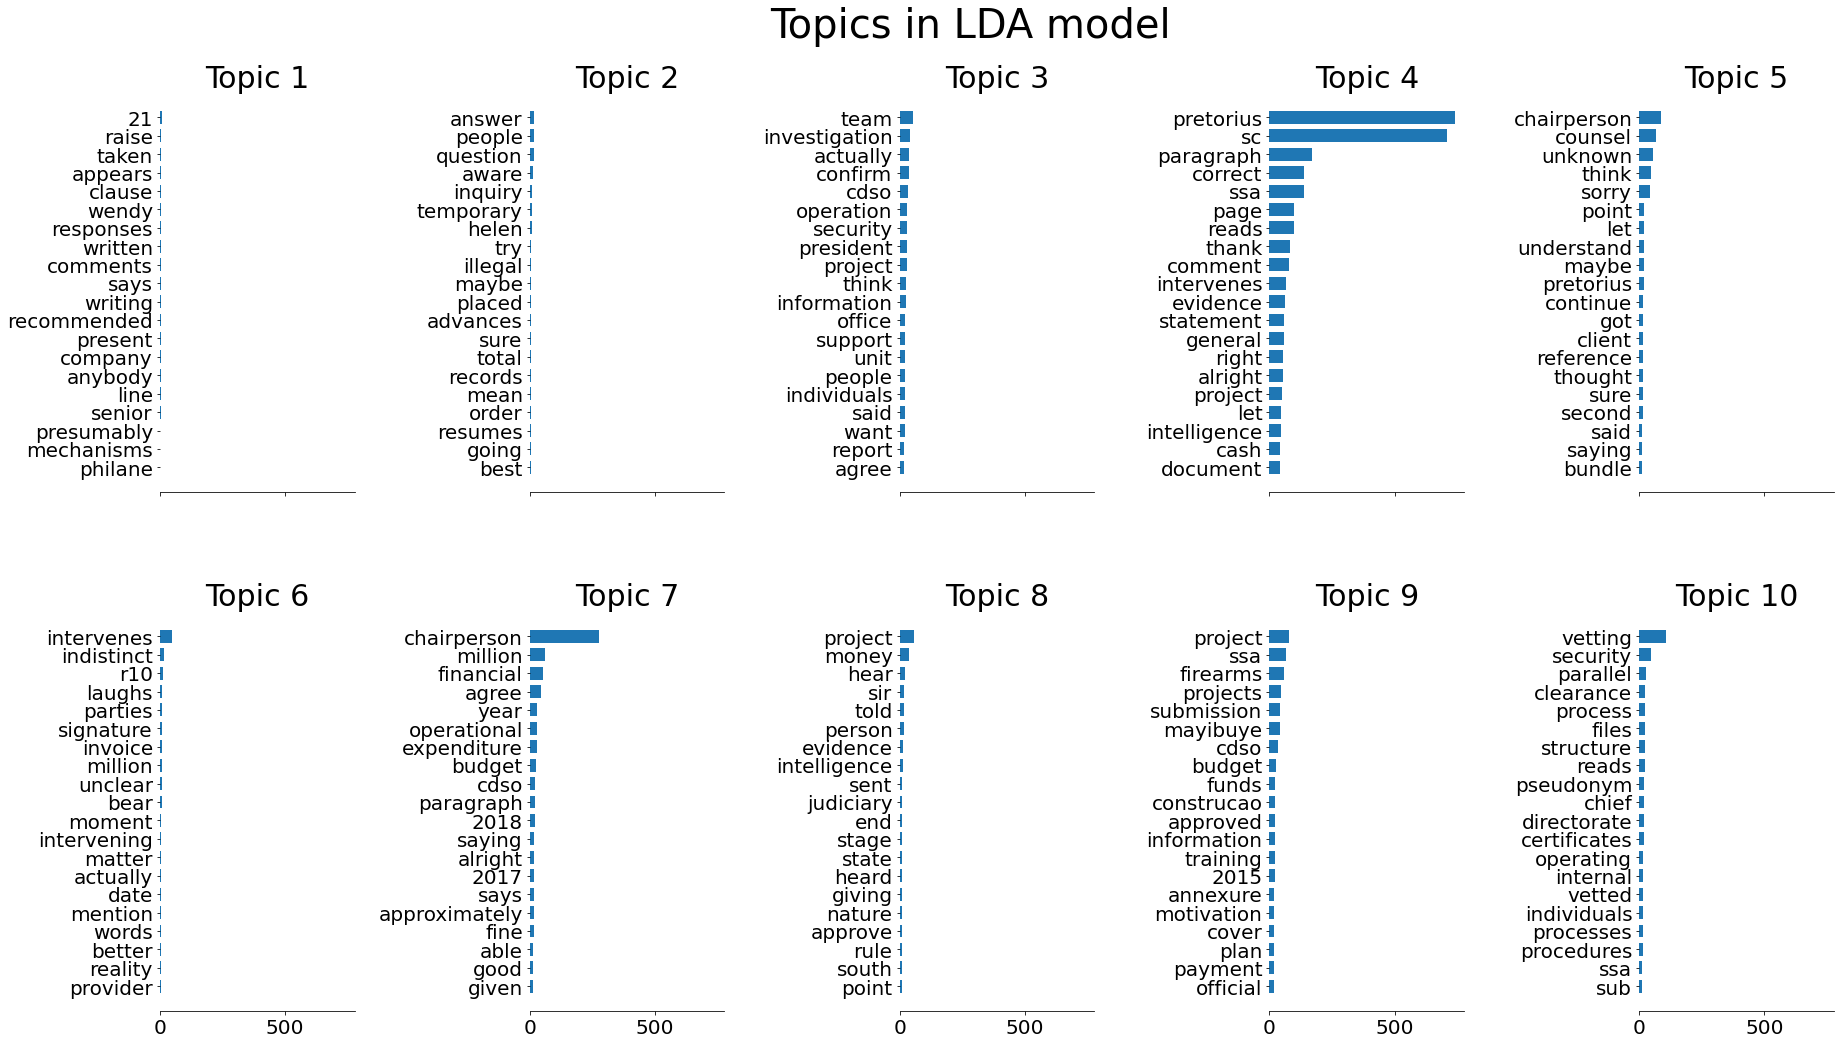

In [9]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the dataset and vectorize it.
print("Loading dataset...")
t0 = time()
data_samples = papers['speech_processed1'][:n_samples]
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')

# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')

print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')